# Credit Card LGBM Example

## 1. INSTALL & LOAD LIBRARIES

In [ ]:
##!apt-get -qq install -y graphviz && pip install -q pydot
##!apt-get install graphviz libgraphviz-dev pkg-config
##!pip install pygraphviz
##!pip uninstall lightgbm -y
##!pip install lightgbm==3.2.0

In [9]:
import os
import pickle
import pydot
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict
from matplotlib.pyplot import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import lightgbm
from lightgbm import LGBMClassifier, plot_tree, create_tree_digraph

In [10]:
lightgbm.__version__

'3.2.0'

## 2. LOAD & PREPROCESS DATASET

데이터셋은 kaggle의 creditcard fraud prediction(?)의 데이터를 사용하였다.

In [46]:
df = pd.read_csv('./drive/MyDrive/colab/creditcard.csv')
X_train, X_test, y_train, y_test = train_test_split(
                                      df.iloc[:, :30],
                                      df.iloc[:, -1],
                                      test_size=0.3,
                                      random_state=100
                                   )

## 3. TRAIN MODEL

모델은 `LGBMClassifier` 를 사용하는데, 후에 결과 분석에서 Tree를 직접 확인해보기 위해 개수를 5개로 제한해서 학습하도록 하겠다.

In [47]:
model = LGBMClassifier(n_estimators=5, max_depth=5, n_jobs=-1, random_state=100)
model.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=5, n_jobs=-1, num_leaves=31, objective=None,
               random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 4. PREDICT MODEL

In [49]:
y_pred = model.predict(X_test)
#y_pred = model.predict_proba(X_test) -> 확률로 확인하고 싶은 경우 Return: [0일 확률, 1일 확률]
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
roc_auc_score(y_test, y_pred)

0.8729346336279596

In [51]:
confusion_matrix(y_test, y_pred)

array([[85249,    52],
       [   36,   106]])

`target = 1`, `pred = 1` 인 데이터를 예시로 확인해보자.

In [52]:
check = df.iloc[281144, :30]
check = check.values.reshape(1, -1)
print("score:", model.predict(check, raw_score=True), " predict:", model.predict(check))

score: [166.46857617]  predict: [1]


모델은 해당 `row` 를 166.4685의 점수로 1일 것이라고 예측을 했음을 확인할 수 있다.

이때 이 점수를 도출하는 과정을 직접 확인해보자.

## 5. EXPLORE TREE

앞에서 설정했듯이 tree의 개수는 총 5개이다.

In [20]:
booster = model.booster_
booster.num_trees()

5

`plot_tree()` 혹은 `create_tree_digraph()` 를 통해 `i` 번째 나무를 확인할 수 있다.

`tree_index=i(default=0)` 를 인자로 넣어주자.

`precision=` 을 통해 소수점 자릿수를 조절할 수 있다.

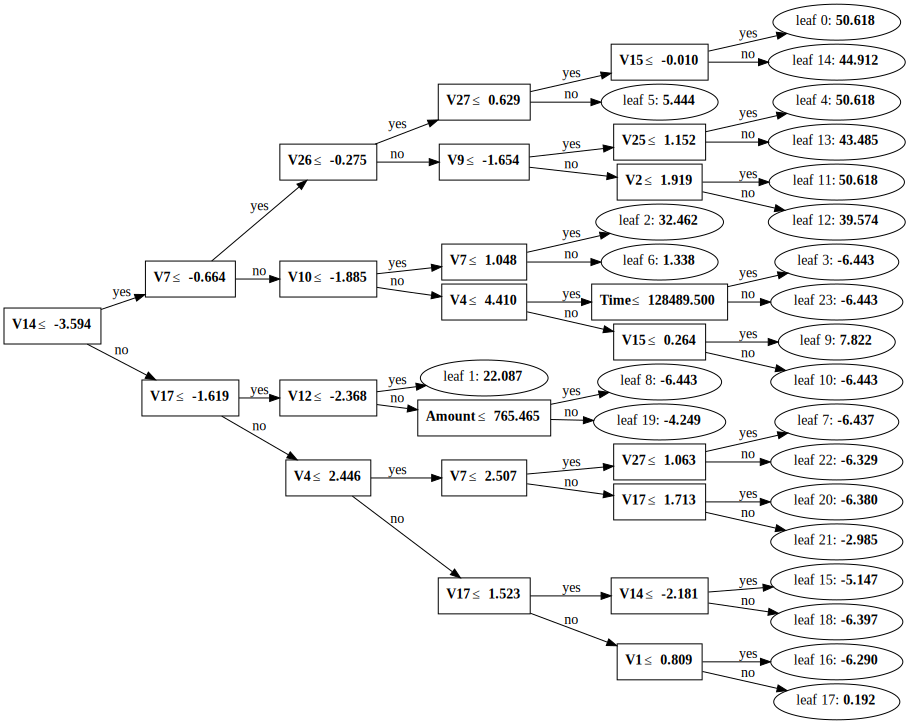

In [22]:
create_tree_digraph(model, tree_index=0, precision=3)

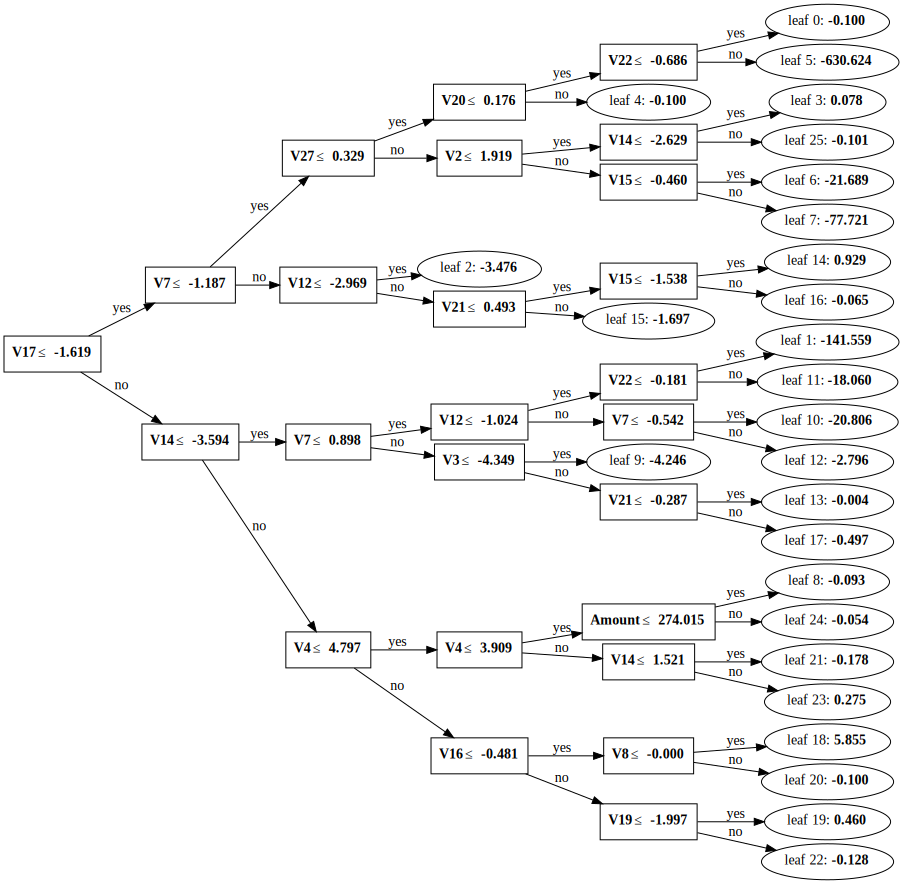

In [23]:
create_tree_digraph(model, tree_index=1, precision=3)

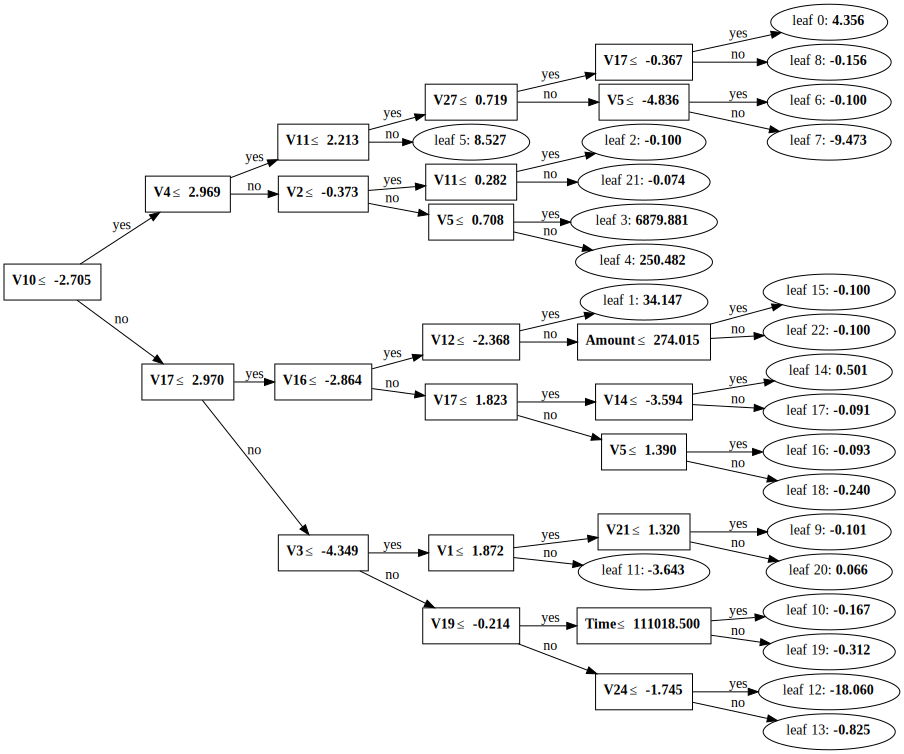

In [24]:
create_tree_digraph(model, tree_index=2, precision=3)

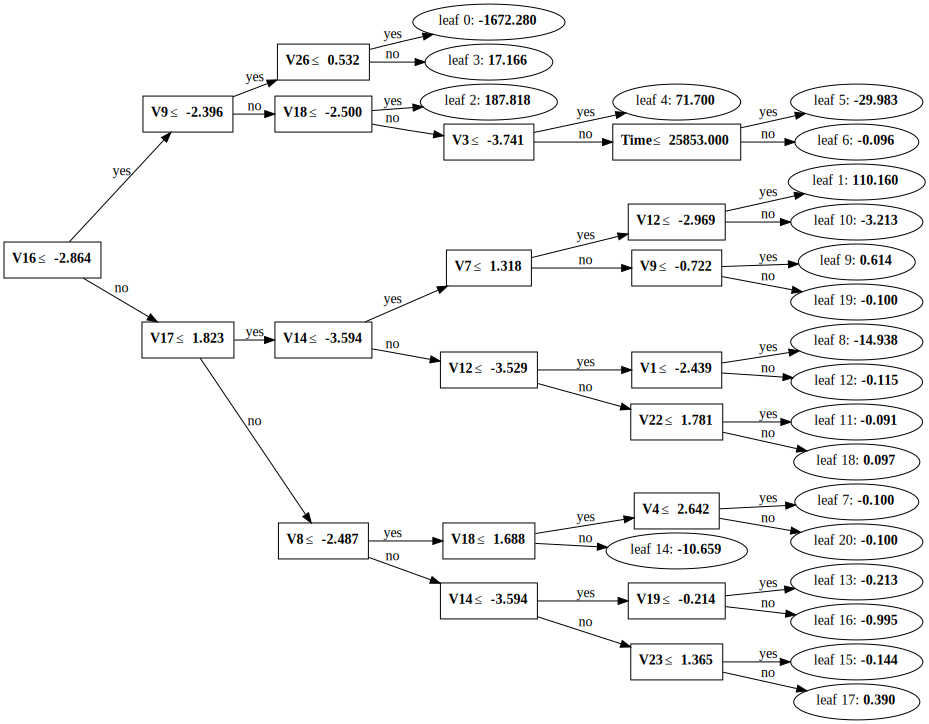

In [25]:
create_tree_digraph(model, tree_index=3, precision=3)

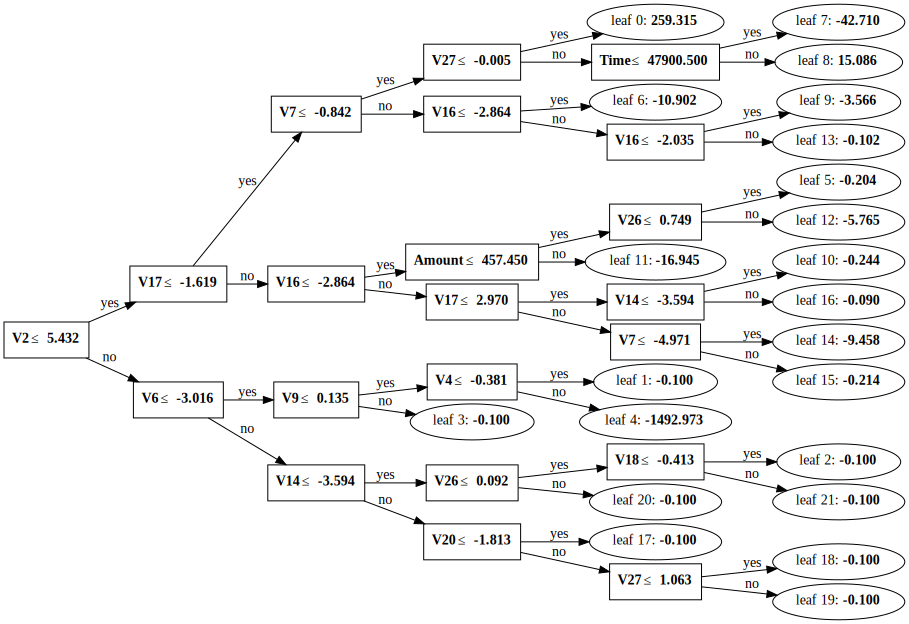

In [26]:
create_tree_digraph(model, tree_index=4, precision=3)

In [27]:
df.iloc[281144, :30]

Time      169966.000000
V1            -3.113832
V2             0.585864
V3            -5.399730
V4             1.817092
V5            -0.840618
V6            -2.943548
V7            -2.208002
V8             1.058733
V9            -1.632333
V10           -5.245984
V11            1.933520
V12           -5.030465
V13           -1.127455
V14           -6.416628
V15            0.141237
V16           -2.549498
V17           -4.614717
V18           -1.478138
V19           -0.035480
V20            0.306271
V21            0.583276
V22           -0.269209
V23           -0.456108
V24           -0.183659
V25           -0.328168
V26            0.606116
V27            0.884876
V28           -0.253700
Amount       245.000000
Name: 281144, dtype: float64

In [41]:
aa = model.predict(check, pred_leaf=True).tolist()
aa = aa[0]

In [43]:
sum_list = []
for i in range(len(aa)):
    sum_list.append(booster.get_leaf_output(i, aa[i]))
    print(booster.get_leaf_output(i, aa[i]))

50.617945732789394
0.07839449006776984
-9.472847232689535
110.15953749174358
15.085545685151704


나무에서 이 row에 해당하는 값들을 넣어주며 해당하는 leaf를 찾고, 그 leaf_value를 모두 더한 것이, 앞서 모델에서 구한 점수임을 확인할 수 있다.

In [44]:
# 281144 predict value
value = sum(sum_list)
model.predict(check, raw_score=True), value

(array([166.46857617]), 166.4685761670629)

이 합산된 점수를 시그모이드 취하면 확률이 나오고, 0.5 이상인 경우 1이라고 예측한다.

In [45]:
# predict class
1 / (1 + np.exp(-1*value))

1.0

## 6. TREES_TO_DATAFRAME & FEATURE_IMPORTANCE

`trees_to_dataframe` 을 통해 tree를 데이터프레임으로 바꿀 수 있다.

In [53]:
booster = model.booster_
booster.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S1,0-S6,None,V14,5.855360e+04,-3.594447,<=,left,None,-6.343200,0.000000,199364
1,0,2,0-S1,0-S3,0-S2,0-S0,V7,7.585870e+04,-0.664390,<=,left,None,14.220500,1.379220,787
2,0,3,0-S3,0-S4,0-S10,0-S1,V26,2.202510e+03,-0.275322,<=,left,None,44.755500,0.511730,292
3,0,4,0-S4,0-S13,0-L5,0-S3,V27,4.880230e+03,0.628870,<=,left,None,32.733100,0.117418,67
4,0,5,0-S13,0-L0,0-L14,0-S4,V15,6.104230e+01,-0.009770,<=,left,None,47.963900,0.075357,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,4,4,4-S17,4-L17,4-S18,4-S16,V20,2.758880e-09,-1.812753,<=,left,None,-0.100128,0.813710,653
223,4,5,4-L17,None,None,4-S17,None,NaN,NaN,None,None,None,-0.100152,0.045105,32
224,4,5,4-S18,4-L18,4-L19,4-S17,V27,3.523350e-09,1.062823,<=,left,None,-0.100127,0.768605,621
225,4,6,4-L18,None,None,4-S18,None,NaN,NaN,None,None,None,-0.100121,0.477408,405


importance_type (string, optional (default="split")) – How the importance is calculated. If “split”, result contains numbers of times the feature is used in a model. If “gain”, result contains total gains of splits which use the feature.

In [54]:
booster.feature_importance(importance_type="split", iteration=0)

array([ 4,  3,  4,  3,  7,  3,  1,  9,  2,  4,  2,  2,  6,  0, 10,  4,  6,
       10,  3,  3,  2,  3,  3,  1,  1,  1,  4,  6,  0,  4], dtype=int32)

In [55]:
booster.feature_importance(importance_type="gain", iteration=0)

array([4.87164598e+03, 1.39572900e+03, 1.99319412e+06, 4.70822502e+03,
       3.21653639e+05, 5.54111945e+06, 4.60011992e+04, 9.28205349e+04,
       1.20565804e+02, 1.42419964e+05, 1.88949099e+04, 1.18670113e+03,
       2.10765371e+04, 0.00000000e+00, 5.91581122e+04, 3.81320946e+03,
       7.40403603e+02, 1.93058587e+03, 9.64313577e+03, 8.02987385e+01,
       2.10175000e+04, 2.59636799e+01, 3.60554500e+04, 5.70907021e+00,
       3.20304993e+02, 1.84464996e+02, 3.08468019e+05, 3.92643557e+04,
       0.00000000e+00, 9.57455506e+02])

In [59]:
dfdf = pd.DataFrame({'name': df.columns[:30],
                     'split': booster.feature_importance(importance_type="split", iteration=0),
                     'gain': booster.feature_importance(importance_type="gain", iteration=0)})

In [60]:
dfdf.sort_values('split', ascending=False)

,name,split,gain
17,V17,10,1.930586e+03
14,V14,10,5.915811e+04
7,V7,9,9.282053e+04
4,V4,7,3.216536e+05
12,V12,6,2.107654e+04
27,V27,6,3.926436e+04
16,V16,6,7.404036e+02
0,Time,4,4.871646e+03
26,V26,4,3.084680e+05
15,V15,4,3.813209e+03
